In [13]:
%pip install -U langsmith
%pip install --upgrade --quiet  langchain-gigachat
%pip install langchain_gigachat


  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
from getpass import getpass

# if "GIGACHAT_CREDENTIALS" not in os.environ:
os.environ["GIGACHAT_CREDENTIALS"] = 'token'

In [ ]:
import requests

url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

payload={
  'scope': 'GIGACHAT_API_PERS'
}
headers = {
  'Content-Type': 'application/x-www-form-urlencoded',
  'Accept': 'application/json',
  'RqUID': 'ba24aa0c-8097-471a-8948-525e7f666bb1',
  'Authorization': f'Basic '
}

response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)

In [31]:
from langchain_gigachat import GigaChat

chat = GigaChat(verify_ssl_certs=False, scope="GIGACHAT_API_PERS")

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = 'true'
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="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"

In [32]:
from langchain_core.messages import HumanMessage, SystemMessage
from langsmith.wrappers import wrap_openai
from langsmith import traceable

@traceable
def start_dialog (input):
    messages = [
        SystemMessage(
            content= input
        ),
        HumanMessage(content="What is capital of Russia?"),
    ]

    print(chat.invoke(messages).content)

print(start_dialog ('кошка - '))

The capital of Russia is Moscow.
None


In [33]:
from langsmith import evaluate, Client
from langsmith.schemas import Example, Run
import json

# 1. Create and/or select your dataset
client = Client()
dataset_name = "my first dataset"
#dataset = client.clone_public_dataset("https://smith.langchain.com/public/a63525f9-bdf2-4512-83e3-077dc9417f96/d", dataset_name=dataset_name)

# 2. Define an evaluator
def is_json(root_run: Run, example: Example) -> dict:
    try:
        json.loads(root_run.outputs["output"])
        return True
    except:
        return False
    
def simp_chat(x):
    messages = [
        SystemMessage(
            content= 'Write json ans'
        ),
        HumanMessage(content=x["question"]),
    ]
    return chat.invoke(messages).content
# 3. Run an evaluation
# For more info on evaluators, see: https://docs.smith.langchain.com/concepts/evaluation#evaluators

# To evaluate an LCEL chain, replace lambda with chain.invoke
# To evaluate a LangGraph graph, replace lambda with graph.invoke
evaluate(
    simp_chat,
    # graph.invoke
    data=dataset_name,
    evaluators=[is_json],
    experiment_prefix="json is"
)

View the evaluation results for experiment: 'json is-4aaf8591' at:
https://smith.langchain.com/o/01cd58a7-eef9-4d4d-8f46-d914573d2088/datasets/f6e7ef8b-e8d4-482d-95cc-ac3583ed622f/compare?selectedSessions=f21cd45f-28e3-4ba1-a520-11c85fd13a20




<ExperimentResults json is-4aaf8591>

### Проверка на выдачу ответа в формате JSON для GigaChat
Видно, что гигачат не справляется с поставленной задачей
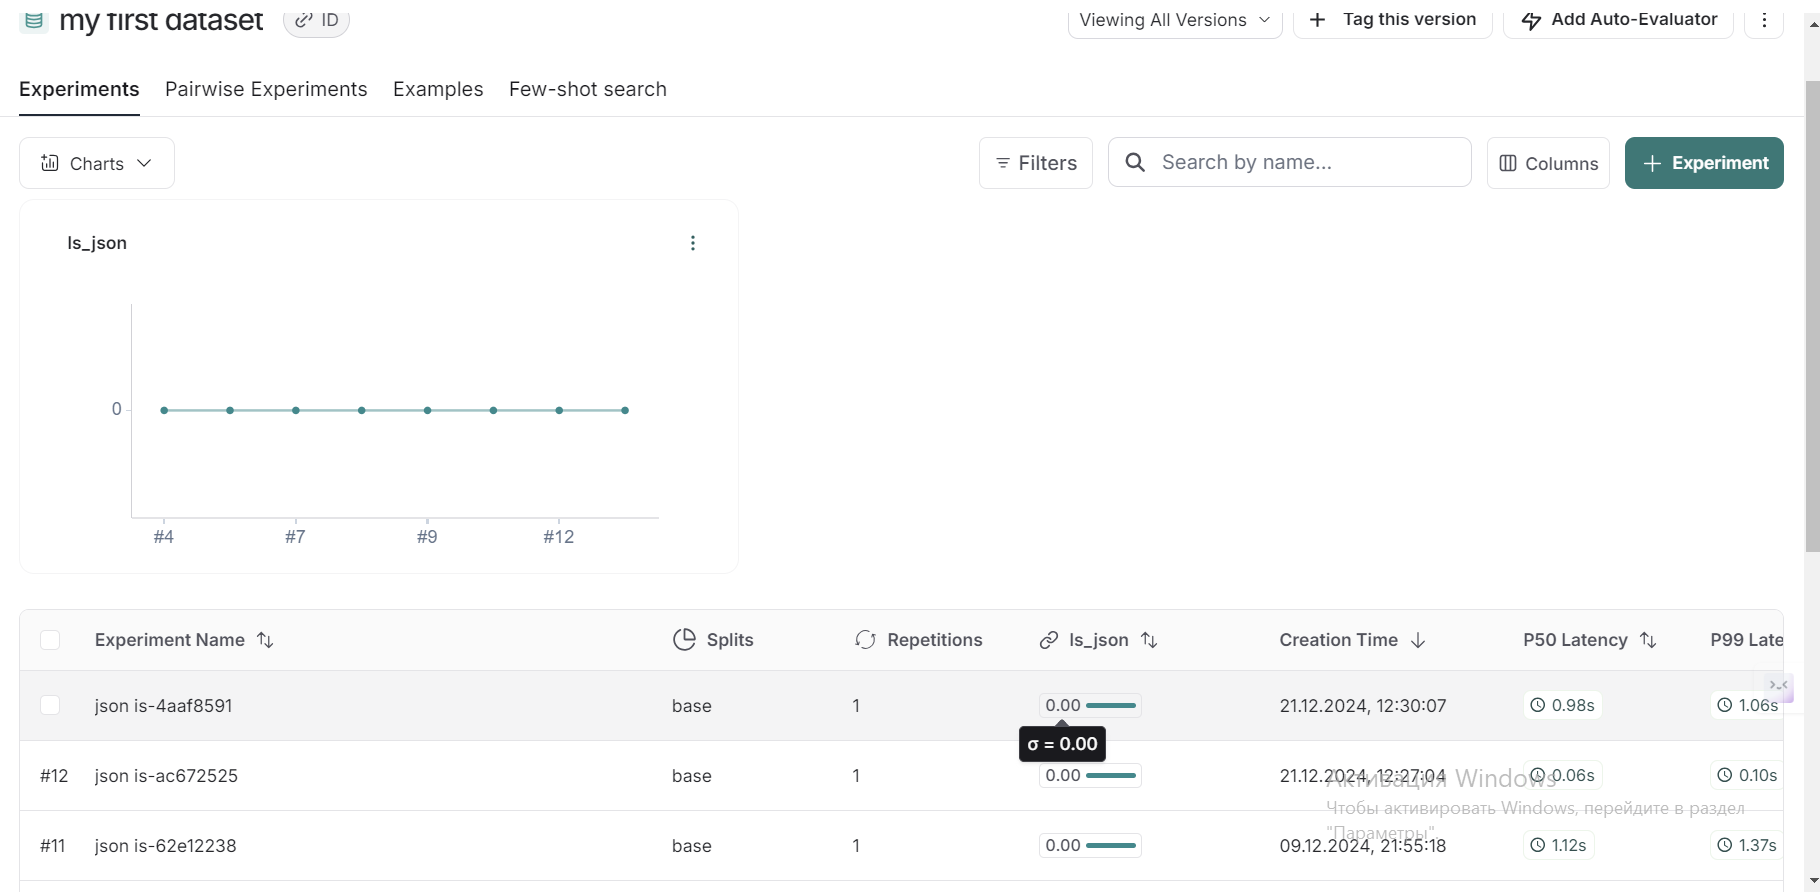

In [4]:
import json

input_file = 'datasets/full_dataset.json'

with open(input_file, 'r',encoding='utf-8') as file:
    data = json.load(file)

print(type(data))
print(data)

<class 'dict'>
{'https://en.wikipedia.org/wiki/History_of_the_periodic_table': {'all_batches': ["Jump to content Main menu Main menu move to sidebar hide Navigation Main pageContentsCurrent eventsRandom articleAbout WikipediaContact us Contribute HelpLearn to editCommunity portalRecent changesUpload file Search Search Appearance Donate Create account Log in Personal tools Donate Create account Log in Pages for logged out editors learn more ContributionsTalk Contents move to sidebar hide (Top) 1 Early history 2 First classification 3 Comprehensive formalizations 4 Priority dispute and recognition Toggle Priority dispute and recognition subsection 41 Mendeleev's predictions and inability to incorporate the rare-earth metals 42 Priority of discovery 43 Recognition of Mendeleev's table 5 Inert gases and ether Toggle Inert gases and ether subsection 51 Inert gases 52 Changes to the periodic table 53 Ether 6 Atomic theory and isotopes Toggle Atomic theory and isotopes subsection 61 Radioacti

In [11]:
def json_to_jsonl(json_data, output_file):
    with open(output_file, 'w') as f:
           for key, value in json_data.items():
            # Создаем объект для каждой записи
            record = value.copy()
            record['url'] = key
            # Записываем объект в формате JSONL
            f.write(json.dumps(record) + '\n')

In [12]:
# Преобразуем и сохраняем в файл
json_to_jsonl(data, 'datasets.jsonl')

In [11]:
def json_to_jsonl(json_data, output_file):
    with open(output_file, 'w') as f:
           for key, value in json_data.items():
            good_line = True
            # Создаем объект для каждой записи
            record = {}
            #record['url'] = key
            record['question'] = value["question"]
            record["answer"] = value["answer"]
           # record["info_rag"] = value["relevant_batches_texts"]
            for k,v in record.items():
                if len(v) == 0:
                    good_line = False
            if good_line:
                # Записываем объект в формате JSONL
                f.write(json.dumps(record) + '\n')

In [12]:
json_to_jsonl(data, 'datasets/q_a_texts_url.jsonl')

In [ ]:
dataset_name = 'ds-ample-depot-26' # in langsmith name

In [4]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = 'true'
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="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"

In [5]:
import os
from mistralai import Mistral

m_api_key = 'uhxHL0aphzJ1WTEJe7C4UoDdnUYlLU9J'
model = "mistral-large-latest"



from langsmith import evaluate, Client
from langsmith.schemas import Example, Run
import json

# 1. Create and/or select your dataset
client = Client()

dataset_name = 'q_a_t_u'

# 2. is right ans on question

def is_json(root_run: Run, example: Example) -> dict:
    try:
        json.loads(root_run.outputs["output"])
        return True
    except:
        return False
    
def is_rigth_ans_with_batch(root_run: Run, example: Example) -> dict:
    try:
        chat_response = m_client.chat.complete(
        model= model,
        messages = [
                    {"role": "user",
                        "content": f"""
                        You are a helpful AI assistant focused on checking ans and question.
                        Your main task is to determine whether the correct answer has been given to the question. 
                        You have a reference answer {example.outputs['answer/0']}, 
                        and here is the actual answer {root_run.outputs["output"]}. 
                        If the actual answer matches, return True;
                        otherwise, return False.
                     """}])

        print(chat_response.choices[0].message.content)
        return True
    except:
        return False
    
def simp_chat(x):
    m_client = Mistral(api_key=m_api_key)
    chat_response = m_client.chat.complete(
        model= model,
        messages = [
                    {"role": "system",
                        "content": """
                        You are a helpful AI assistant focused on answering questions based on provided context.
                     Your core responsibilities:

                    - Use only information from the given context.
                    - When you reference information from a source, cite it by adding the source number in square brackets at the end of the sentence (e.g., [1]).
                    - Use the source numbers as provided in the Sources section.
                    - Acknowledge limitations when context is insufficient.
                    - Highlight any contradictions in sources.
                    - Respond in the same language as the question is asked.
                    - do not write ['''json] before {, get only {} 

                    Format your responses as:
                    {
                        "Answer": "[detailed response with sources citations in square brackets]",
                        "Sources": {
                            source_id: "[source link]",
                            ...
                        }
                        }"""
                    },
            {
                "role": "user",
                "content": f"""Here is the relevant context:

                    {x['info_rag/0']}
                    {x['info_rag/1']}
                    {x['info_rag/2']}
                    {x['info_rag/3']},
                    {x['info_rag/4']}

                    Question: {x['question']}

                    Please provide a complete answer following the required format.""",
                                },
                            ])
    return chat_response.choices[0].message.content
# 3. Run an evaluation
# For more info on evaluators, see: https://docs.smith.langchain.com/concepts/evaluation#evaluators

# To evaluate an LCEL chain, replace lambda with chain.invoke
# To evaluate a LangGraph graph, replace lambda with graph.invoke
evaluate(
    simp_chat,
    data=dataset_name,
    evaluators=[is_json, is_rigth_ans_with_batch],
    experiment_prefix="json is"
)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\langsmith\client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


LangSmithAuthError: Authentication failed for /datasets. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/datasets?limit=1&name=q_a_t_u', '{"detail":"Invalid token"}')

In [ ]:
#TODO:
#1) посчитать насколько эталоный ответ соотвествует нашему (mistral + gpt) (до понедельника) -> вечер воскресение/утро понедельника
# остальное насколько смогу(3* если есть нужный batch)




1) проверить соответствует формату вывода ответ  : { "ans"："текст ответа", "links"：["ссылки на использованные источники", "ссылка 2", "и тд"]} . добавить в работу чата , если что перегенерировать. 

2) проверка возможности модели адекватно различать информацию необходимою для ответа из батчей. Требования к формату теста :  1 тест : {"sources "：［{ "url"："URL значение", "batch_id"：" батч  ид значение ", "text":"текст"}, {...}］, "question":"вопрос пользователя ", "need_sources": ["batche_id", "",]}. Нужно  сделать вопрос и список батчей для него на тестовом датасете , батчи могут быть релевантными и нерелевантными.  Нужно  списке need batche  указать необходимые для запроса. В тесте должно быть 3 выборки : 1) все источники подходят 2) часть источников подходят (можно разбить на подвыборку от 1 до 5 подходят например ) 3) все не подходят

3-5) 
3) корректность ответа
4) корректность подбора батча под вопрос
5) корректность использования батча 
Формат теста { "question" :"", ans:"", "sources": "：［{ "url"："URL значение", "batch_id"：" батч  ид значение ", "text":"текст"}, {..}],